# Analiza: Wykrywanie języka na podstawie częstotliwości słów w tekscie

Celem tej pracy jest ocena, czy na podstawie danych dotyczących częstotliwości występowania słów w arytkule na wybranym wiki (u nas bulbapedia) da się rozpoznać język tekstu. Eksperyment polega na porównaniu listy najczęsciej występujących słów na wiki z listą najczęściej występujących słów w jednym z trzech języków. Sprawdzimy dodatkowo jak na poprawność metody wpływa długość arytkułu.

In [44]:
# Początkowe importy najważniejszych modułów i bibliotek
import re
import matplotlib.pyplot as plt
from wordfreq import top_n_list, word_frequency
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd

Wykorzystamy listy najczęsciej występujących słów z trzech języków: polskiego, angielskiego (język naszej wiki), oraz niemieckiego. Użyjemy do tego biblioteki wordfreq.

In [45]:
# Zwraca liniową ilość wystąpień słowa 'na jedno słowo' w języku
def get_language_words(lang: str, n: int = 1000) -> dict[str, float]:
    words = top_n_list(lang, n)
    return {w: word_frequency(w, lang) for w in words}

langs = ["en", "pl", "de"]

lang_freq = {lang: get_language_words(lang) for lang in langs}

Na potrzeby analizy stworzymy nowy uniwersalny scraper, który zadziała dla każdej strony, nie tylko bulbapedii.

In [46]:
# Nasza funkcja scrapująca zwraca obiekt bs, który potem będziemy edytować zależnie od struktury html
def get_article(url):
    # Tworzymy header, który pozwoli nam się dostać do stron używając headera z httpbin.org/cache
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:147.0) Gecko/20100101 Firefox/147.0"
    }

    try:
        source = requests.get(url, headers=headers)
    except requests.RequestException:
        return None

    if source.status_code != 200:
        print(f"Błąd: status_code={source.status_code} dla {url}")
        return None

    return BeautifulSoup(source.text, "html.parser")


Jako dłuższy artykuł z wybranej wiki (bulbapedii) posłuży strona z opisami umiejętności pokemonów: [https://bulbapedia.bulbagarden.net/wiki/Ability]. Pobierzmy html tej strony używając naszej nowej funkcji.

In [47]:
lo_soup = get_article("https://bulbapedia.bulbagarden.net/wiki/Ability")

Zrobimy to samo dla krótkiego arytkuły ze strony [https://bulbapedia.bulbagarden.net/wiki/Caterpie_Forest], który pełen jest nazw własnych oraz nie ma wielu słów charakterystyczmych dla języka.

In [48]:
sh_soup = get_article("https://bulbapedia.bulbagarden.net/wiki/Caterpie_Forest")

Robimy to również dla artykułów w każdym z wybranych języków:

In [49]:
pl_soup = get_article("https://wolnelektury.pl/katalog/lektura/witkacy-o-czystej-formie.html")
en_soup = get_article("https://en.wikipedia.org/wiki/Beer")
de_soup = get_article("https://wolnelektury.pl/katalog/lektura/heyse-die-schwarze-jakobe.html")

# Usuwamy polskie słowa z niemieckiego tekstu (bo pobieramy z polskiej strony)
for h2 in de_soup.find_all("h2"):
    h2.decompose()

Zdefiniujmy funkcję do liczenia słów zwracającą słownik:

In [50]:
def count_words(text) -> dict:
    word_dict = {}

    for word in text:
        word_dict[word] = word_dict.get(word, 0) + 1

    return word_dict


Teraz musimy w każdej z tych struktur znaleźć właściwą zawartość z artykułem, zamienić ją na tekst i policzyć słowa:

In [51]:
# Wycinanie właściwej zawartości (find zwraca typ tag)
sh_content = sh_soup.find("p")
lo_content = lo_soup.find("div", class_="mw-body-content")
pl_content = pl_soup.find("div", class_="main-text-body")
en_content = en_soup.find("div", id="mw-content-text")
de_content = de_soup.find("div", class_="main-text-body")

contents = {
    "short_en": sh_content,
    "long_en": lo_content,
    "pl_article": pl_content,
    "en_article": en_content,
    "de_article": de_content,
}

dicts = {}

for name, c in contents.items():
    # Zmieniamy typ na string
    text = c.get_text(" ", strip=True)

    # Tokenizacja
    tokens = re.findall(r"[^\W\d_]+", text.lower())
    # Tworzymy słowniki z licznikiem wystąptień
    res: dict[str, int] = count_words(tokens)
    # Sortujemy
    sorted_dict = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    # Wstawiamy do dicts
    dicts[name] = sorted_dict


Upewnijmy się, że wszystko działa wypisując pare pierwszych słów:

In [52]:
for name, d in dicts.items():
    print(name)
    print(list(d.items())[:100])

short_en
[('caterpie', 2), ('forest', 2), ('is', 2), ('frosterpie', 2), ('the', 1), ('a', 1), ('pokémon', 1), ('fan', 1), ('site', 1), ('run', 1), ('by', 1), ('it', 1), ('also', 1), ('known', 1), ('as', 1), ('fcf', 1), ('s', 1)]
long_en
[('the', 847), ('s', 540), ('pokémon', 500), ('in', 428), ('a', 286), ('ability', 285), ('to', 280), ('its', 247), ('and', 241), ('of', 237), ('it', 168), ('moves', 139), ('abilities', 132), ('from', 121), ('battle', 118), ('when', 114), ('activated', 113), ('used', 110), ('with', 110), ('is', 108), ('by', 93), ('iii', 91), ('that', 87), ('type', 80), ('stat', 70), ('was', 68), ('damage', 63), ('as', 62), ('have', 61), ('hidden', 58), ('or', 56), ('iv', 55), ('attack', 54), ('vii', 53), ('an', 52), ('v', 52), ('ix', 50), ('power', 49), ('viii', 48), ('be', 47), ('if', 47), ('boosts', 45), ('ash', 44), ('for', 43), ('effects', 43), ('has', 43), ('series', 39), ('hit', 39), ('generation', 38), ('will', 38), ('against', 38), ('other', 37), ('hp', 37), ('up

Pora zdefiniować funckje szacującą język tekstu. Pomysł: liczymy współczynnik **COVERAGE** czyli jaka część wszystkich słów w tekście należy do top-N słów danego języka oraz **COSINE SIMILARITY** czyli proporcja tych top-słów w tekście do proporcji w profilu języka (wpisujemy słowa w wektory i patrzymy na kąt pomiędzy nimi mówiący czy idą w tą samą stronę). Wynikiem końcowym będzie coverage * cosine. Zacznijmy od funkcji porównującej proporcje, wzór to:
$$
\cos(\theta)=\frac{x\cdot y}{\|x\|\|y\|}
$$
Gdzie $0^\circ$ oznacza całkowite podobieństwo, a $90^\circ$ jego brak. Nie otrzymamy ujemych wartości bo wszystkie el. w wektorach są dodatnie.

Nasza norma wektora to:
$$
\|x\| = \sqrt{\sum_{i=1}^{n} x_i^2}
$$


In [53]:
def cosine_similarity(vec_a: dict[str, float], vec_b: dict[str, float]) -> float:
    # Ustalamy wspólną liste słów dla obu wektorów
    keys = set(vec_a.keys()) | set(vec_b.keys())

    # Iloczyn skalarny wektorów i ich normy
    dot = 0.0 
    norm_a = 0.0
    norm_b = 0.0

    # Iterujemy po każdym słowie i uzupełniamy dane
    for k in keys:
        a = vec_a.get(k, 0.0)
        b = vec_b.get(k, 0.0)

        dot += a * b
        norm_a += a * a
        norm_b += b * b

    # Obliczamy normy
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)

    # Dla wektorów pustych zwróć 0 dopasowania
    if norm_a == 0.0 or norm_b == 0.0:
        return 0.0
    
    # Zwróc współczynnik cos pomiędzy 0 a 90 stopni
    return dot / (norm_a * norm_b)


Zdefiniujmy funkcję, która na bazie coverage i cosine similarity obliczy współczynnik dopasowania języka, zwracającą wynik 0..1 gdzie 0 to brak dopasowania a 1 to pewne dopasowanie.

In [54]:
def lang_confidence_score(word_counts: dict[str, int],
                          language_words_with_frequency: dict[str, float],
                          k=1000) -> float:
    # Wybierzmy top k słów języka aby dostać k par (słowo : częstotliwość)
    topk = sorted(language_words_with_frequency.items(), key=lambda x: x[1], reverse=True)[:k]
    # Lista samych słów
    topk_words = [w for w, _ in topk]

    # Policzymy total do normalizacji słów wiki
    total = sum(word_counts.values())
    if total <= 0:
        return 0.0
    
    # Obliczmy nasz coverage czyli procent słów z wiki pojawiający się w top_k
    in_topk = sum(word_counts.get(w, 0) for w in topk_words)
    coverage = in_topk / total

    # Tworzymy wektor (słownik) słowo - częstotliwość do naszej funckji cosine
    sum_lang = sum(fr for _, fr in topk)
    # Normalizujemy
    if sum_lang == 0:
        return 0.0
    lang_vec = {w: fr / sum_lang for w, fr in topk}
    
    # Robimy to samo dla wektora słów wiki 
    art_vec = {w: word_counts.get(w, 0) for w in topk_words}
    sum_doc = sum(art_vec.values())
    if sum_doc == 0:
        return 0.0
    doc_vec = {w: c / sum_doc for w, c in art_vec.items()}

    cos = cosine_similarity(doc_vec, lang_vec)

    return float(cos * coverage)

Trzeba policzyc i zapisać uporządkowane wyniki do jednego DataFrame.

In [55]:
ks = [3, 10, 100, 1000]

rows = []
for lang_name, lang_dict in lang_freq.items():
    for name, count in dicts.items():
        for k in ks:
            score = lang_confidence_score(count, lang_dict, k=k)
            rows.append({
                "language": lang_name,
                "doc": name,
                "k": k,
                "score": score,
            })

df = pd.DataFrame(rows)
print(df)

   language         doc     k     score
0        en    short_en     3  0.039143
1        en    short_en    10  0.098248
2        en    short_en   100  0.171372
3        en    short_en  1000  0.218513
4        en     long_en     3  0.093535
5        en     long_en    10  0.170567
6        en     long_en   100  0.302312
7        en     long_en  1000  0.422693
8        en  pl_article     3  0.003838
9        en  pl_article    10  0.015364
10       en  pl_article   100  0.018181
11       en  pl_article  1000  0.023747
12       en  en_article     3  0.086672
13       en  en_article    10  0.173822
14       en  en_article   100  0.264871
15       en  en_article  1000  0.437372
16       en  de_article     3  0.000000
17       en  de_article    10  0.002866
18       en  de_article   100  0.007095
19       en  de_article  1000  0.009910
20       pl    short_en     3  0.000000
21       pl    short_en    10  0.000000
22       pl    short_en   100  0.008669
23       pl    short_en  1000  0.013210


Z gotowych danych pozostaje zrobić nam wykresy:

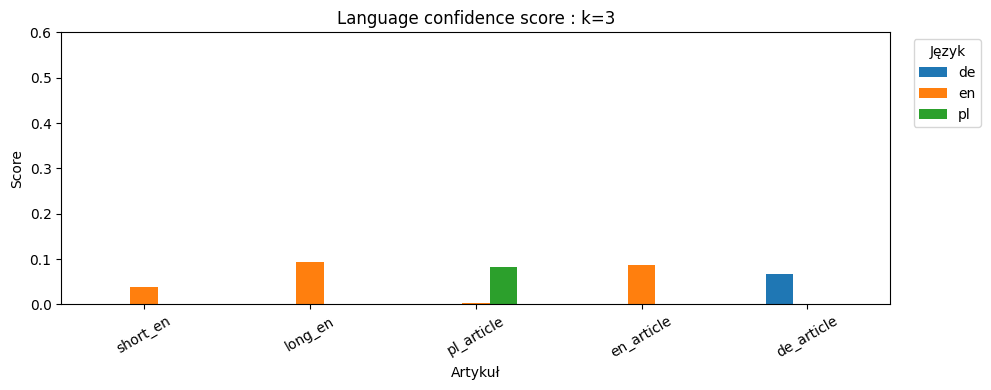

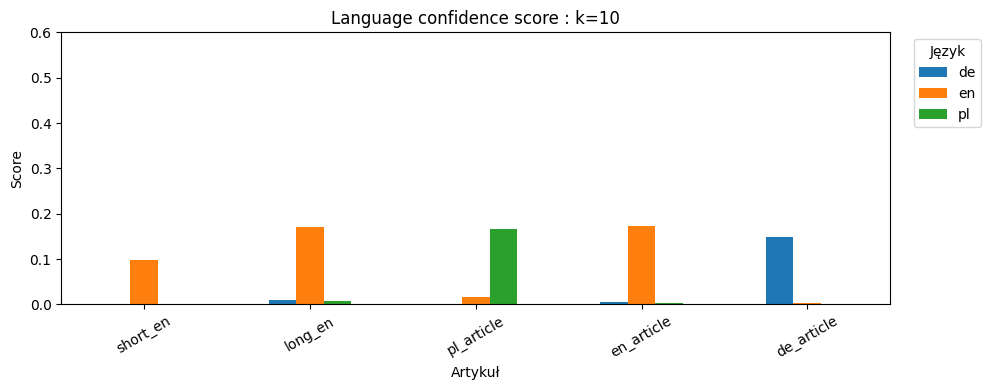

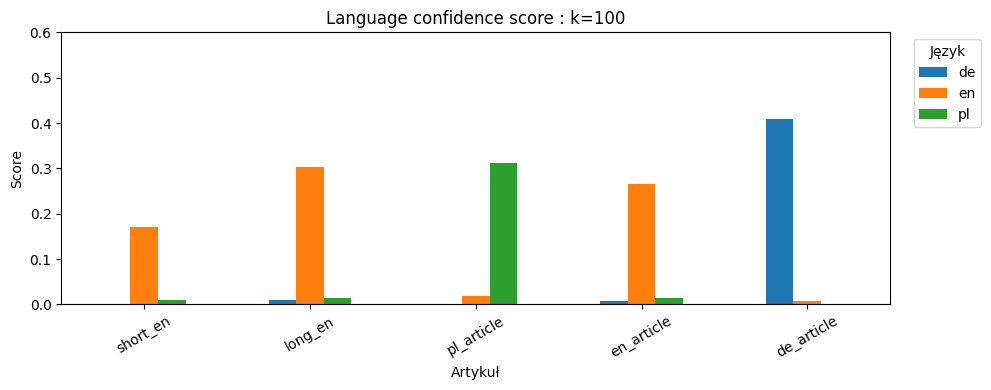

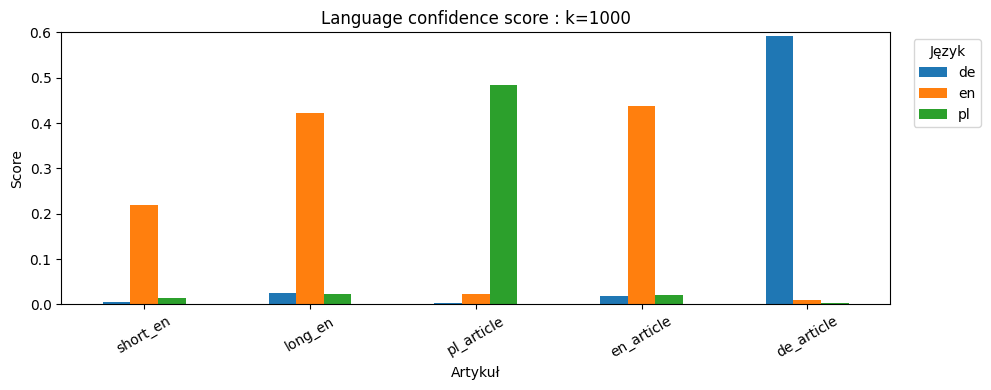

In [56]:
# doc to nazwy naszych artykułów wybrane z df
doc = df['doc'].unique()

# Każde K to oddzielny wykres
for k in ks:
    # Bierzemy z naszego df wiersze dla aktualnego k
    sub = df[df["k"] == k]

    # Robimy tabelę: wiersze = dokumenty, kolumny = języki, wartości = score
    pivot = sub.pivot(index="doc", columns="language", values="score")

    # Wymuszamy kolejność dokumentów jak w doc_order
    pivot = pivot.loc[doc]

    # Rysujemy wykres słupkowy z danych pivot..
    ax = pivot.plot(kind="bar", figsize=(10, 4))

    # Tytuł wykresu
    ax.set_title(f"Language confidence score : k={k}")

    # Opisy osi
    ax.set_xlabel("Artykuł")
    ax.set_ylabel("Score")

    # Stałe y dla normalizacji
    ax.set_ylim(0, 0.6)

    # Obrót etykiet na osi X, żeby się mieściły
    ax.tick_params(axis="x", rotation=30)

    # Legenda poza wykresem (po prawej), żeby nie zasłaniała słupków
    ax.legend(title="Język", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Dopasowanie marginesów, żeby wszystko (np. legenda) się zmieściło
    plt.tight_layout()

    # Wyświetlenie wykresu
    plt.show()


## PODSUMOWANIE ##
1. Analizując wykresy funkcji zauważamy, że współczynnik dopasowania języka do tego, w którym strona została faktycznie napisana rośnie proporcjonalnie do współczynnika k. Jest to naturalne, im większa próbka słów, tym dopasowanie pewniejsze.
2. Proporcjonalnie wyniki dla różnych k nie różnią się, tzn. np dla pełnego nazw własnych short_en już od k = 10 pojawiają się sugestie wystąpienia języka polskiego lub niemieckiego lecz ich proporcja do faktycznego języka jest zachowana. Dzieje się to przez odmiany słów, kórych łapiemy coraz więcej.
3. Najmniej różnorodne pod względem ilości języków na artykuł jest oczywiści k = 3 gdzie występuje tak naprawdę tylko faktyczny język, ze względu na małą próbke.
4. Widzimy, że skuteczność dopasowania będziemy tak naprawdę oceniać po różnicy wysokości najbardziej prawdopodobnego języka, a dwóch pozostałych. Dla niemieckiego artykułu np. język jest pewny a dla short_en występuje rozproszenie na dwa pozostałe języki.
5. Dobór języków miał znaczenie, polski i niemiecki, które mają znaki charakterystyczne łatwiej jest wykryć niż angielski. Szczególnie niemiecki co widać po ostatim wykresie.
6. W samych wartościach score widać pośrednio wpływ odmiany: dla języków fleksyjnych (PL i DE) wynik rośnie znacznie mocniej po zwiększeniu k, co sugeruje, że dopasowanie wymaga uwzględnienia większej liczby form wyrazów. To jest spójne z tym, że częste słowa w tych językach występują w wielu odmienionych wariantach, więc przy małym k miara “łapie” ich mniej, a dopiero większe k obejmuje więcej odmian.
7. Znalezienie słabego artykułu było bardzo ciężkie, nasza funkcja jest na tyle dobra, że i tak daje miarodajne efekty. Artykuł, który udało mi się wybrać jest krótki, ma dużo nazw własnch i małą zgodność najczęstszych słów z językiem w którym jest napisany, to powoduje, że słupek jest dwa razy mniejszy niż dłuższych artykułów w języku angielskim. Słupek short_en rośnie też dużo wolniej wraz ze wzrostem k, w porównaniu do innych artykułów.